In [ ]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

**1. Load the Dependencies**

In [ ]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
import tensorflow as tf
import pandas as pd
import json
import gc
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**2. Load the Training Data**

In [1]:
# # Load the Training Dataset

import pandas as pd

df = pd.read_csv('Datasetmerged_data_equal.csv')


In [2]:
df['Label'].unique()

**2. Clean The Data**

In [ ]:
import re

def remove_noise(text):
    if isinstance(text, str):
        # Remove punctuation using string.punctuation
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'[@#]', '', text)  # Remove special characters like @ and #
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs and website links
        text = re.sub(r'[!(){}\[\]]', '', text)  # Remove additional special characters
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        return text
    else:
        return text


df['Text'] = df['Text'].apply(remove_noise)


**Assign the Label**

In [3]:
# Define a custom mapping
label_mapping = {'human': 0, 'bot': 1}

# Map the labels to their corresponding numeric values
df['numeric_label'] = df['Label'].map(label_mapping)

# Display the first few rows to verify the mapping
print(df.head())


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame after mapping labels
# Split the DataFrame into two based on labels
df_human = df[df['Label'] == 'human']
df_bot = df[df['Label'] == 'bot']

# Sample 5000 rows from each DataFrame
df_human_sampled = df_human.sample(n=5000, random_state=42)
df_bot_sampled = df_bot.sample(n=5000, random_state=42)

# Concatenate the two sampled DataFrames back into one
df = pd.concat([df_human_sampled, df_bot_sampled])

# Shuffle the combined DataFrame so that the order of rows is random
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows to verify the changes
print(df.head())


                                           text_data  Label  numeric_label
0  In a statement the US Secret Service said it w...    bot              1
1   Archaeologist Unit ZVK401   https  wwwyoutube...  human              0
2  dont worry about me Ill find something else to...  human              0
3  I could change the world The possibilities Do ...  human              0
4  Phone and driving Essay\n\nToday The majority ...  human              0


In [ ]:
# Get the count of each unique label
label_counts = df['Label'].value_counts()

# Print the count of each unique label
print("Count of each label:")
print(label_counts)


Count of each label:
bot      5000
human    5000
Name: Label, dtype: int64


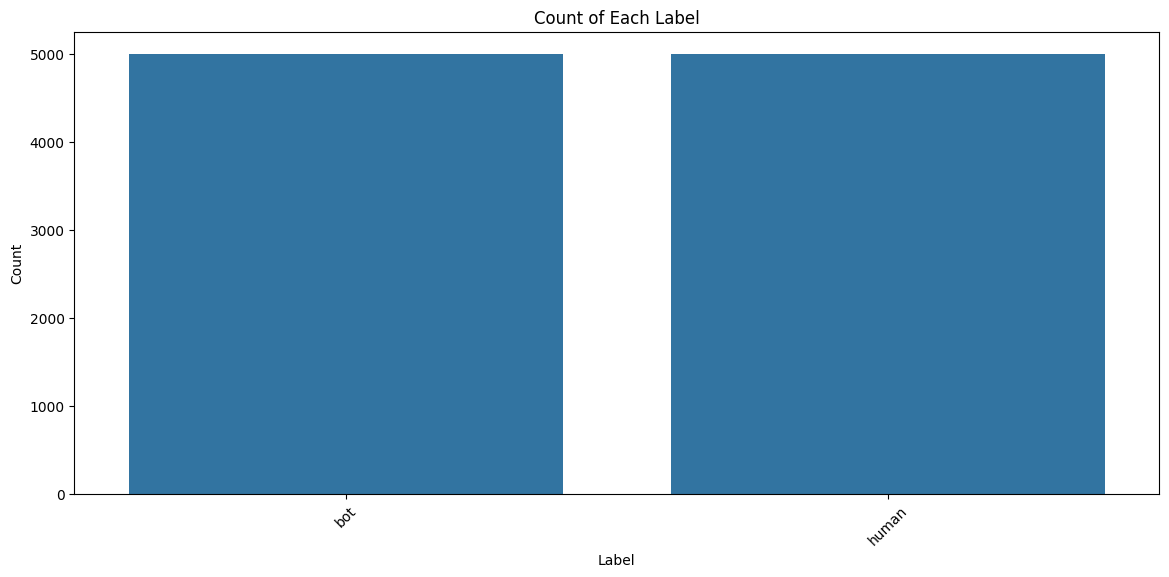

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the count of each label
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='Label')
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
# In order to load the model from hugging face, we need to import transformer
# We need also to import 1. AutoModelForSequenceClassification and 2. AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# Just Copy the name of model from hugging
model_name = 'junaid1993/bot_detection_model'
# First embed the tokenizer into the model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Now, load the modelname+Tokenizer using AutoModelForSequenceClassification.
model = AutoModelForSequenceClassification.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



In [ ]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [ ]:
# Print the first few examples of the 'text_data' column
print(df['text_data'].head())


0    In a statement the US Secret Service said it w...
1     Archaeologist Unit ZVK401   https  wwwyoutube...
2    dont worry about me Ill find something else to...
3    I could change the world The possibilities Do ...
4    Phone and driving Essay\n\nToday The majority ...
Name: text_data, dtype: object


In [ ]:
df['text_data'] = df['text_data'].astype(str)


In [ ]:
tokenized_inputs = tokenizer(list(df['text_data']), padding=True, truncation=True, return_tensors="pt", max_length=512)

In [ ]:
# Extract the tokenized inputs
input_ids = tokenized_inputs["input_ids"]
attention_masks = tokenized_inputs["attention_mask"]

# If you're using PyTorch and plan to create a DataLoader later on
# Convert these to PyTorch datasets
from torch.utils.data import TensorDataset

# Assuming 'numeric_label' is your target variable
labels = torch.tensor(df['numeric_label'].values)

# Create a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% training, 20% testing)
train_text, test_text, train_labels, test_labels = train_test_split(df['text_data'], df['numeric_label'], test_size=0.2, random_state=42)

# Split training data into training and validation sets (80% training, 20% validation)
train_text, val_text, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.2, random_state=42)



In [ ]:
train_encodings = tokenizer(list(train_text), truncation=True, padding=True)
val_encodings  = tokenizer(list(val_text), truncation=True, padding=True)
test_encodings = tokenizer(list(test_text), truncation=True, padding=True)

In [ ]:

# Convert lists of input IDs and attention masks to tensors
train_input_ids_tensor = torch.tensor(train_encodings['input_ids'])
train_attention_masks_tensor = torch.tensor(train_encodings['attention_mask'])
val_input_ids_tensor = torch.tensor(val_encodings['input_ids'])
val_attention_masks_tensor = torch.tensor(val_encodings['attention_mask'])
test_input_ids_tensor = torch.tensor(test_encodings['input_ids'])
test_attention_masks_tensor = torch.tensor(test_encodings['attention_mask'])

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)
test_labels_tensor = torch.tensor(test_labels.values)

# Create PyTorch datasets
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_input_ids_tensor, train_attention_masks_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_input_ids_tensor, val_attention_masks_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_input_ids_tensor, test_attention_masks_tensor, test_labels_tensor)


In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):

    # Extract true labels and predicted class labels
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute binary classification metrics
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }


In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:

# Define a custom collation function for the DataLoader
def custom_collate_fn(batch):
    input_ids = torch.stack([item[0] for item in batch])
    attention_masks = torch.stack([item[1] for item in batch])
    labels = torch.tensor([item[2] for item in batch])  # Convert labels to tensor
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }

# Create TrainingArguments
training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=8
)

# Create Trainer object with custom collation function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=custom_collate_fn
)

# Train the model
trainer.train()


Step,Training Loss
500,0.294700


TrainOutput(global_step=800, training_loss=0.2246087074279785, metrics={'train_runtime': 19419.8862, 'train_samples_per_second': 0.33, 'train_steps_per_second': 0.041, 'total_flos': 847791351398400.0, 'train_loss': 0.2246087074279785, 'epoch': 1.0})

In [ ]:
save_directory = '/content/output'

In [ ]:
trainer.save_model(save_directory)

In [ ]:
tokenizer.save_pretrained(save_directory)

('/content/output/tokenizer_config.json',
 '/content/output/special_tokens_map.json',
 '/content/output/vocab.json',
 '/content/output/merges.txt',
 '/content/output/added_tokens.json',
 '/content/output/tokenizer.json')

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi


In [ ]:
api = HfApi()

In [ ]:
api.upload_folder(
    folder_path="/content/output",
    path_in_repo = ".",
    repo_id="junaid1993/bot_detetcion_updated_Model",
    repo_type="model"
)

rng_state.pth:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/657M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

events.out.tfevents.1710199420.f7a869ee8a27.2051.0:   0%|          | 0.00/5.20k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/junaid1993/bot_detetcion_updated_Model/commit/a75788787943e64f60546ba66d1327d26bfd01c2', commit_message='Upload folder using huggingface_hub', commit_description='', oid='a75788787943e64f60546ba66d1327d26bfd01c2', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# Evaluate the model on the validation set
results = trainer.evaluate()

# Print evaluation results
for key, value in results.items():
    print(f"{key}: {value}")


eval_loss: 0.08787842839956284
eval_Accuracy: 0.97625
eval_Precision: 0.9598540145985401
eval_Recall: 0.9937027707808564
eval_F1-score: 0.9764851485148516
eval_runtime: 1375.3874
eval_samples_per_second: 1.163
eval_steps_per_second: 0.145
epoch: 1.0


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('/content/output')
tokenizer = AutoTokenizer.from_pretrained('/content/output')

# Define the input text
input_text = "This is a sample text by ChatGPT"

# Tokenize and preprocess the input text
inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt")

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

# Extract predicted probabilities and class labels
predicted_probabilities = torch.softmax(outputs.logits, dim=1)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

# Map class labels to human-readable format
class_names = ['human-generated', 'bot-generated']
predicted_class = class_names[predicted_labels.item()]

print(f"Predicted Class: {predicted_class}")


Predicted Class: bot-generated


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the model and tokenizer from Hugging Face
model_name = "junaid1993/bot_detetcion_updated_Model"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define the input text
input_text = "This is a sample text by ChatGPT"

# Tokenize and preprocess the input text
inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt")

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

# Extract predicted probabilities and class labels
predicted_probabilities = torch.softmax(outputs.logits, dim=1)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

# Map class labels to human-readable format
class_names = ['human-generated', 'bot-generated']
predicted_class = class_names[predicted_labels.item()]

print(f"Predicted Class: {predicted_class}")


config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Predicted Class: bot-generated


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('/content/output')
tokenizer = AutoTokenizer.from_pretrained('/content/output')

# Get the number of classes (assuming binary classification)
num_classes = model.config.num_labels

# Map output indices to human-readable class labels
class_labels = ['human-generated', 'bot-generated']  # Replace with your actual class labels

# Print the class labels
print("Classes that the model will predict:")
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")


Classes that the model will predict:
Class 0: human-generated
Class 1: bot-generated
